In [1]:
from pathlib import Path
from cc_model.load_datasets import load_gt_dataset_cached


import graph_tool.all as gt
from cc_model.wl import WL, labelings_are_equivalent
from cc_model.fast_graph import FastGraph
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib

rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [3]:
datasets = [#"karate", 
            "phonecalls",
            "HepPh", 
            "AstroPh", 
#            "web-Google",
#             "soc-Pokec"
#            "deezer_HR", "deezer_HU", "deezer_RO","tw_musae_DE",
#            "tw_musae_ENGB","tw_musae_FR","lastfm_asia","fb_ath",
#            "fb_pol", "facebook_sc"
           ]

In [4]:
dataset_path = Path("/home/felix/projects/colorful_configuration/datasets")

In [5]:
epsilon=1e-20
max_iter = 500

In [6]:
names_to_eigenvalues = {
    "karate":      6.725697727631732,
    "phonecalls" : 13.125956990198913,
    "HepPh":       20, #5.6629203197371965,
    "AstroPh":     94.4415437598996,
    "web-Google":  37.639582115220364,
    "soc-Pokec":   118.52742163417824}

In [43]:
def rewire_run_katz_for_round(G, depth, in_base_katz, *, alpha, number_of_rewires=10, verbosity=0):
    """ Calculate similarities in pagerank vectors for rewired G
    G :      FastGraph
    depth:    depth of WL iteration to be used
    in_base_pagerank :    in pagerank of G
    Generate synthethic networks which have the same WL colors as G
      at specific depth and return absolute error sum
    """
    pagerank_args = {"mode" :"in",
                     "alpha":alpha,
                     "beta": 1.0,
                     "epsilon":epsilon,
                     "max_iter":max_iter,
                     "return_err":True}
    
    errors = []
    for i in range(number_of_rewires):
        G.rewire(depth)
        #eigenvalue = get_eigenvalue(G)
        #print(eigenvalue, alpha * eigenvalue)
        
        in_katz, err = G.calc_katz(**pagerank_args)
        if err<0:
            print("iteration did not converge")
            eigenvalue = get_eigenvalue(G)
            print(f"eigenvalue was {eigenvalue}; prefactor was {alpha * eigenvalue}")
        if verbosity > 0:
            print("the error in pagerank is:\r\n", err)
        katz_diff = np.sum(np.abs(in_base_katz-in_katz))
        errors.append(katz_diff)

    return errors

In [44]:
def get_eigenvalue(G):
    G_gt = G.to_gt(switch=False)
    value, vector = gt.eigenvector(G_gt, epsilon = 1e-12, max_iter=1000)
    return value

def compute_ev_on_all_datasets(n_rewires, verbosity=0):
    """ computes pagerank and compares it with rewired graphs
    """
    list_values = []
    list_stds = []
    for dataset in datasets:
        if dataset is None:
            list_means.append([])
            list_stds.append([])
            continue
        if verbosity > 0:
            print(dataset)
        G_base = load_gt_dataset_cached(dataset_path,
                                        dataset,
                                        verbosity=verbosity,
                                        force_reload=False)
        edges = np.array(G_base.get_edges(), dtype=np.uint32)
        
        G = FastGraph(edges, G_base.is_directed())
        
        # Adjusting alpha
        if dataset in names_to_eigenvalues:
            ev = names_to_eigenvalues[dataset]
        else:
            print("calculating eigenvalue")
            ev = get_eigenvalue(G)
        print("eigenvalue", dataset, ev)
        # make sure alpha is lower then the inverted eigenvalue
        alpha=2/3 * 1/ev
        
        values = get_MAE_for_iterations(G,
                                        n_rewires=n_rewires,
                                        alpha = alpha)
        

        #print(WL_fast(to_symmetric_edges(G._edges)))
        #print(G.base_partitions)
        list_values.append(values)
    return list_values

In [45]:
def to_symmetric_edges(edges):
    n_edges = edges.shape[0]
    out = np.empty((2 * n_edges,2), dtype=edges.dtype)
    out[:n_edges,:]=edges
    out[n_edges:,1]=edges[:,0]
    out[n_edges:,0]=edges[:,1]
    return out

In [46]:
import numpy as np
from numba import njit
from numba import int64, uint32, float64

@njit([(int64[:,:], int64, float64, float64, float64, int64), (uint32[:,:], int64, float64, float64, float64, int64, )])
def katz_numba_sym(edges, num_nodes, alpha, beta, epsilon, max_iter):
    """
    G: Graph
    max_iter: maximum number of iterations.
    eps: convergence parameter
    -> break iteration if L1-norm of difference between old and new pagerank vectors are smaller than eps
    """
    #num_nodes = len(degrees)

    v = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    v_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    num_iter = 0
    last_err = 1
    while last_err > epsilon and num_iter < max_iter:
        for i in range(num_nodes):
            v_old[i] = v[i]
            v[i] = 0
        
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            v[e1] += v_old[e2]
            v[e2] += v_old[e1]
            
        for i in range(num_nodes):
            v[i] = alpha * v[i] + beta

        # compute error
        last_err = 0
        for i in range(num_nodes):
            last_err += abs(v[i] - v_old[i])
        num_iter += 1

    if num_iter >= max_iter:
        last_err = - last_err
         #warnings.warn("Power iteration has not converged up to specified tolerance")

    return v, last_err


@njit([(int64[:,:], int64, float64, float64, float64, int64), (uint32[:,:], int64, float64, float64, float64, int64, )])
def katz_numba_dir(edges, num_nodes, alpha, beta, epsilon, max_iter):
    """
    G: Graph
    max_iter: maximum number of iterations.
    eps: convergence parameter
    -> break iteration if L1-norm of difference between old and new pagerank vectors are smaller than eps
    """
    #num_nodes = len(degrees)

    v = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    v_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    num_iter = 0
    last_err = 1
    while last_err > epsilon and num_iter < max_iter:
        for i in range(num_nodes):
            v_old[i] = v[i]
            v[i] = 0



        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            #v[e1] += v_old[e2]
            v[e2] += v_old[e1]
            
        for i in range(num_nodes):
            v[i] = alpha * v[i] + beta
        #norm = np.sum(v)
        #v/=norm

        # compute error
        last_err = 0
        for i in range(num_nodes):
            last_err += abs(v[i] - v_old[i])
        num_iter += 1

    if num_iter >= max_iter:
        last_err = - last_err
         #warnings.warn("Power iteration has not converged up to specified tolerance")

    return v, last_err


In [47]:
def calc_katz(self, mode, alpha, beta, epsilon, max_iter, return_err=False):
    if not self.is_directed:
        #print((self.edges).dtype, (self.in_degree+self.out_degree).dtype)
        vector, err =  katz_numba_sym(self.edges, 
                                      len(self.in_degree),
                                      alpha,
                                      beta,
                                        epsilon,
                                        max_iter)
    else:

        if "base" in mode:
            edges = self._edges
        else:
            edges = self.edges
        if "in" in mode:
#                dead_ends = self.out_dead_ends
            pass
        elif "out" in mode:
#                dead_ends = self.in_dead_ends
            edges = switch_in_out(edges)

        vector, err =  katz_numba_dir(edges,
                                        len(self.in_degree),
                                      alpha,
                                      beta,
                                        epsilon,
                                        max_iter)
    if return_err:
        return vector, err
    else:
        return vector
FastGraph.calc_katz = calc_katz

In [48]:
def katz_dict_to_array(d):
    arr = np.zeros(len(d))
    for key, value in d.items():
        arr[key] = value
    return arr

In [49]:
def get_MAE_for_iterations(G, n_rewires, *, alpha):
    values = []
    G.ensure_edges_prepared(initial_colors=None)
    #print(G.dead_arr.sum(axis=1)/G._edges.shape[0])
    in_base_katz, err = G.calc_katz("base in",
                              epsilon=epsilon,
                                  alpha=alpha,
                                     beta=1.0,
                             max_iter=max_iter,
                              return_err=True)
    compare_to_nx = False
    if compare_to_nx:
        G_nx = G.to_nx(switch=False)
        import networkx as nx
        katz_dict = nx.katz_centrality(G_nx,
                                       alpha=alpha,
                                       beta=1.0,
                                       normalized=False,
                                       tol = epsilon)
        #vector = np.array(vector.get_array())
        #vector = vector/sum(vector)
        katz_arr = katz_dict_to_array(katz_dict)
        print("in_base_katz", in_base_katz/in_base_katz.max())
        print("katz_dict", katz_arr/katz_arr.max())
        #return []
        #print(in_base_ev, err)
        print("max_katz_error", (in_base_katz - katz_arr).max())
    print("total WL iterations ", G.wl_iterations)
    #print(G.base_partitions.shape)
    #print(G.edges.shape)
    for WL_round in range(G.wl_iterations-1,-1,-1):
        if verbosity>0:
            print("WL round", WL_round)

        MAEs = rewire_run_katz_for_round(G,
                                             WL_round,
                                             in_base_katz,
                                         alpha=alpha,
                                             number_of_rewires=n_rewires,
                                             verbosity=0)
        #print(MAEs)
        values.append(MAEs)
    return values

In [50]:
#karate
#eigenvalue 6.725697727631732

#phonecalls
#eigenvalue 13.125956990198913

#HepPh
#eigenvalue 5.6629203197371965

#AstroPh
#eigenvalue 94.4415437598996

#web-Google
#eigenvalue 37.639582115220364

#soc-Pokec
#eigenvalue 118.52742163417824


In [51]:
from cc_model.fast_wl import WL_fast


In [52]:
verbosity=1
number_of_samples = 100
list_values = compute_ev_on_all_datasets(number_of_samples, verbosity=1)

phonecalls
eigenvalue phonecalls 13.125956990198913
resetting
total WL iterations  9
WL round 8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
HepPh
eigenvalue HepPh 20
resetting
total WL iterations  8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
AstroPh
eigenvalue AstroPh 94.4415437598996
resetting
total WL iterations  5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0


In [53]:
print()
now = datetime.now()
if number_of_samples > 10:
    save_prefix = now.strftime("%Y_%m_%d__%H_%M_%S")
    out_name = "./results/"+"_katz_"+save_prefix+".pkl"
    print(out_name)
    with open(out_name, "wb") as f:
        pickle.dump((list_values, datasets), f)


./results/_katz_2022_01_05__15_40_26.pkl


In [61]:
def get_median_quantiles(list_values):
    list_medians = []
    list_stds0 = []
    list_stds1 = []

    for values in list_values:
        median = np.median(values)+1e-20
        quantiles = np.quantile(values, [0.5-0.68/2, 0.5+0.68/2,])
        #quantiles = np.quantile(values, [0.05, 0.95])
        list_medians.append(median)
        list_stds0.append(quantiles[0])
        list_stds1.append(quantiles[1])
    list_stds = [list_stds0[::-1], list_stds1[::-1]]
    return list_medians[::-1], list_stds

def quickplot(list_values, datasets, show_alpha=False, save_date=None, xlim=None):
    a=8
    plt.figure(figsize=(a,a/2))
    if show_alpha:
        x=np.linspace(0,15)
        y=2 *alpha**(x+1)
        plt.plot(x,y)
    
    markers = [".", "o", "<", "s", "*"]
    markers2 = ["^", "o", "+", "x", "_"]
    marker_sizes = 6*np.array([1.4, 1, 1.5, 1, 1.9,])
    


    for values, label, marker, ms in zip(list_values, datasets, markers2, marker_sizes):
        means, stds = get_median_quantiles(values)
        plt.errorbar(x=np.arange(1,len(means)+1),y=means, yerr=stds, label=label, fmt=marker+"--", markersize=ms)


    plt.ylabel("SAE of Katz centrality")
    plt.xlabel("depth $d$")
    plt.xticks([1,3,5,7,9])
    if xlim is not None:
        plt.xlim(*xlim)
    plt.yscale("log")
    #plt.legend()
    #
    if save_date is None:
        plt.title("Convergence of Katz for synthetic networks ")
    else:
        time_str = save_date.strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig(Path(".")/Path('images')/f'katz_{time_str}.pdf', bbox_inches = 'tight')
    

In [62]:
#quickplot(list_values, datasets, show_alpha=False, save_date=datetime.now())

In [63]:
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
load_dataset=True
if load_dataset:
    load_date = datetime(2022,1,6, 0,18,32)
    save_prefix = load_date.strftime("%Y_%m_%d__%H_%M_%S")
    with open("./results/"+"_katz_"+save_prefix+".pkl", "rb") as f:
        (list_values2, datasets2) = pickle.load(f)

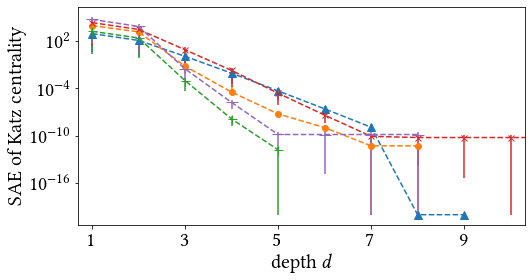

In [64]:
quickplot(list_values2, datasets2, save_date=load_date, xlim=(-0.3+1,10.3))